# Resimulation analysis

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D

In [15]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from model.model_nile import ModelNile
from model.model_nile_scenario import ModelNileScenario
from experimentation.data_generation import generate_input_data
from plotter import HydroModelPlotter

Read the results of the open exploration:

In [13]:
experiments.iloc[0,7:171]

v0      0.031535
v1      0.337122
v2       0.48728
v3      0.264365
v4      0.406114
          ...   
v159    0.258722
v160    0.211918
v161    0.766847
v162    0.212388
v163    0.164798
Name: 0, Length: 164, dtype: object

In [14]:
nile_model = ModelNile()
nile_model = generate_input_data(nile_model)
nile_model.evaluate(experiments.iloc[0,7:171])

(26292.07519366593, 442.8059876290672, 0.0, 0.0, 0.0, 66136264.424087375)

In [18]:
nile_model_s = ModelNileScenario()
uncertainty_parameters = {
            "yearly_demand_growth_rate": 0.2,
            "blue_nile_mean_coef": 1,
            "white_nile_mean_coef": 1,
            "atbara_mean_coef": 1,
            "blue_nile_dev_coef": 1,
            "white_nile_dev_coef": 1,
            "atbara_dev_coef": 1
        }
nile_model_s.evaluate(experiments.iloc[0,7:171], uncertainty_parameters)

(3597401.0745922825,
 41642.997859146504,
 0.575,
 482685.4120145438,
 6844.386802096449,
 66136264.424087375)

In [3]:
experiments = pd.read_csv("../outputs/experiments_resimulation.csv").drop(columns="Unnamed: 0")
outcomes = pd.read_csv("../outputs/outcomes_resimulation.csv").drop(columns="Unnamed: 0")

In [4]:
experiments

,yearly_demand_growth_rate,blue_nile_mean_coef,white_nile_mean_coef,atbara_mean_coef,blue_nile_dev_coef,white_nile_dev_coef,atbara_dev_coef,v0,v1,v2,...,v157,v158,v159,v160,v161,v162,v163,scenario,policy,model
0,0.2,1.00,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,0.487280,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,Baseline,Policy0,NileProblem
1,0.3,1.25,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,0.487280,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,HighD_HighB,Policy0,NileProblem
2,0.3,0.75,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,0.487280,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,HighD_LowB,Policy0,NileProblem
3,0.1,1.25,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,0.487280,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,LowD_HighB,Policy0,NileProblem
4,0.1,0.75,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,0.487280,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,LowD_LowB,Policy0,NileProblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,0.2,1.00,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,0.158378,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,Baseline,Policy849,NileProblem
4246,0.3,1.25,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,0.158378,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,HighD_HighB,Policy849,NileProblem
4247,0.3,0.75,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,0.158378,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,HighD_LowB,Policy849,NileProblem
4248,0.1,1.25,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,0.158378,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,LowD_HighB,Policy849,NileProblem


In [5]:
outcomes

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
0,3.597401e+06,41642.997859,0.575000,4.826854e+05,6844.386802,6.613626e+07
1,1.302909e+07,166600.498853,0.625000,2.405999e+06,33435.022682,1.027969e+08
2,1.306758e+07,166600.498853,0.775000,2.528026e+06,34303.519870,3.716323e+07
3,6.943102e+05,7206.271252,0.125000,9.382364e+03,0.000000,1.027969e+08
4,7.844791e+05,7712.703954,0.608333,3.777331e+04,647.804305,3.716321e+07
...,...,...,...,...,...,...
4245,3.579520e+06,41639.097618,0.591667,4.943120e+05,7144.490597,3.079404e+07
4246,1.301344e+07,166600.498852,0.633333,2.412824e+06,33657.550537,5.207523e+07
4247,1.305516e+07,166600.498853,0.770833,2.529948e+06,33657.758183,7.320082e+06
4248,6.754381e+05,6916.313802,0.141667,1.924297e+04,2.267908,9.234012e+07


In [6]:
def normalize_objs(df, directions):
    desirability_couples = list()
    working_df = df.copy()
    for i, col in enumerate(df.columns):
        if directions[i] == "min": best, worst = df[col].min(), df[col].max()
        elif directions[i] == "max": best, worst = df[col].max(), df[col].min()
        desirability_couples.append((worst, best))
        working_df[col] = (df[col] - worst) / (best - worst)
        
    return working_df, desirability_couples

---------------------------------
Baseline
---------------------------------


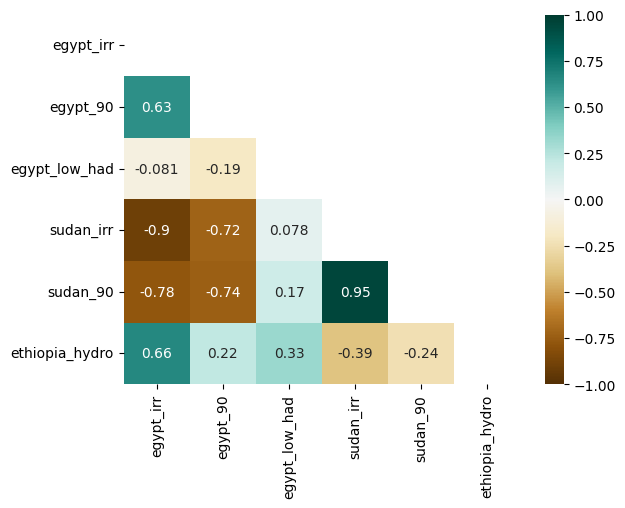

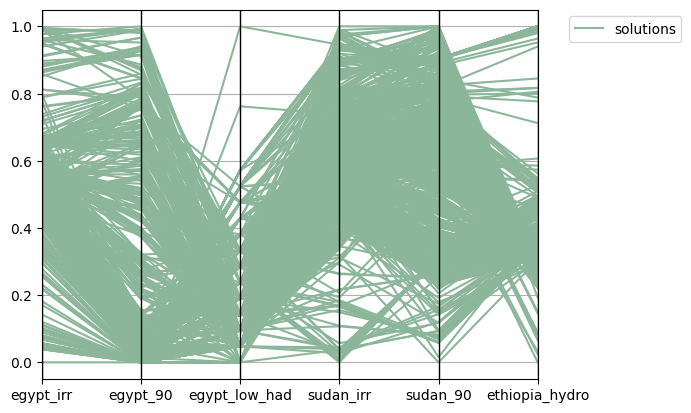

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        1.000000  0.594909      -0.427430  -0.875115 -0.635045   
egypt_90         0.594909  1.000000      -0.065038  -0.675361 -0.645626   
egypt_low_had   -0.427430 -0.065038       1.000000   0.186833  0.187427   
sudan_irr       -0.875115 -0.675361       0.186833   1.000000  0.754320   
sudan_90        -0.635045 -0.645626       0.187427   0.754320  1.000000   
ethiopia_hydro   0.642086  0.077397      -0.456381  -0.263238 -0.157703   

                ethiopia_hydro  
egypt_irr             0.642086  
egypt_90              0.077397  
egypt_low_had        -0.456381  
sudan_irr            -0.263238  
sudan_90             -0.157703  
ethiopia_hydro        1.000000  
          egypt_irr      egypt_90  egypt_low_had      sudan_irr     sudan_90  \
count  8.500000e+02    850.000000     850.000000     850.000000   850.000000   
mean   3.579858e+06  41624.915571       0.610015  494413.376502  7131.852591   
std

<ipython-input-8-f08829f939ff>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_df, dtype=np.bool))


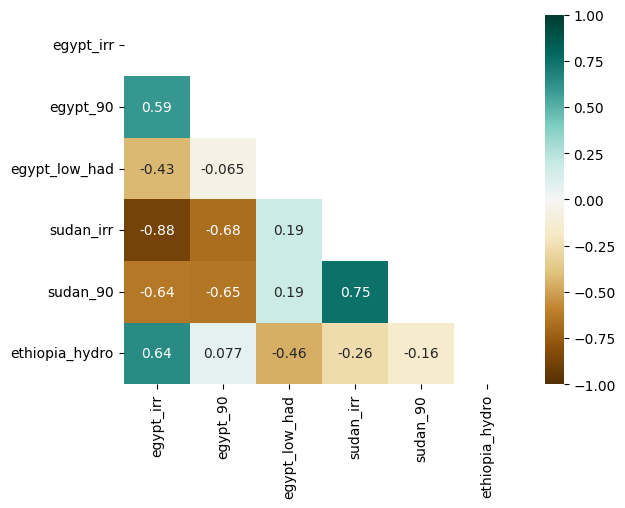

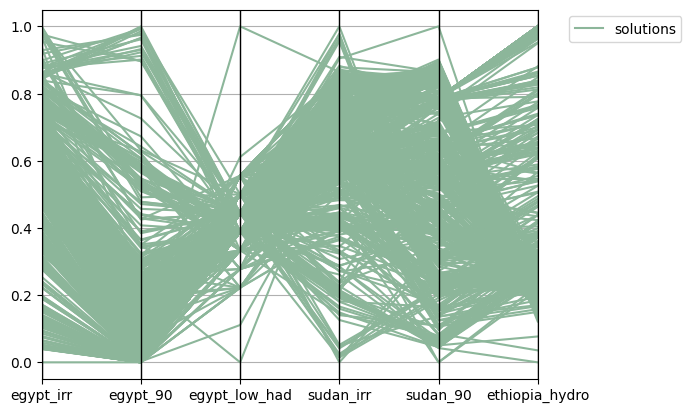

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        1.000000  0.610796      -0.380797  -0.697344 -0.227849   
egypt_90         0.610796  1.000000      -0.187494  -0.708028 -0.530377   
egypt_low_had   -0.380797 -0.187494       1.000000   0.211907  0.012885   
sudan_irr       -0.697344 -0.708028       0.211907   1.000000  0.641727   
sudan_90        -0.227849 -0.530377       0.012885   0.641727  1.000000   
ethiopia_hydro   0.801301  0.245401      -0.276903  -0.191857  0.026254   

                ethiopia_hydro  
egypt_irr             0.801301  
egypt_90              0.245401  
egypt_low_had        -0.276903  
sudan_irr            -0.191857  
sudan_90              0.026254  
ethiopia_hydro        1.000000  
          egypt_irr       egypt_90  egypt_low_had     sudan_irr      sudan_90  \
count  8.500000e+02     850.000000     850.000000  8.500000e+02    850.000000   
mean   1.301590e+07  166600.498852       0.634534  2.412016e+06  33595.926586   


<ipython-input-8-f08829f939ff>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_df, dtype=np.bool))


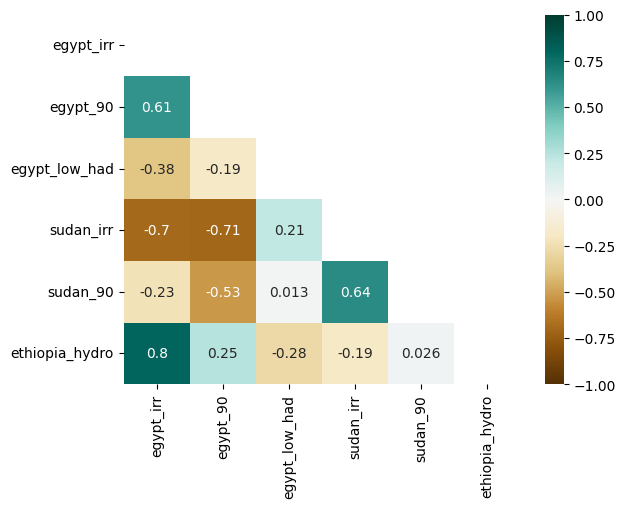

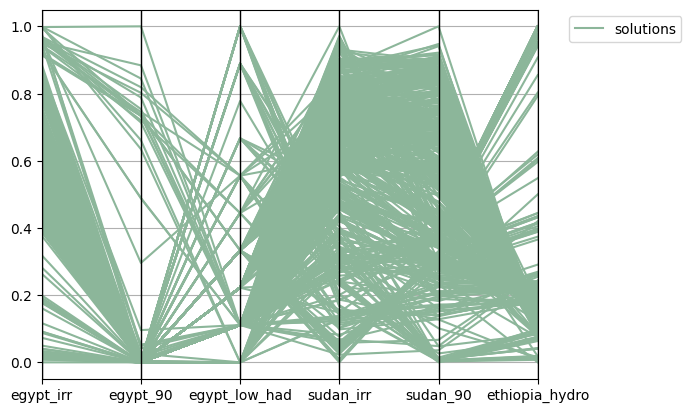

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        1.000000  0.344558       0.179943  -0.629934 -0.115780   
egypt_90         0.344558  1.000000       0.065611  -0.402345 -0.287861   
egypt_low_had    0.179943  0.065611       1.000000  -0.309820 -0.422853   
sudan_irr       -0.629934 -0.402345      -0.309820   1.000000  0.701248   
sudan_90        -0.115780 -0.287861      -0.422853   0.701248  1.000000   
ethiopia_hydro   0.664101  0.010143       0.169934   0.082554  0.312133   

                ethiopia_hydro  
egypt_irr             0.664101  
egypt_90              0.010143  
egypt_low_had         0.169934  
sudan_irr             0.082554  
sudan_90              0.312133  
ethiopia_hydro        1.000000  
          egypt_irr      egypt_90  egypt_low_had     sudan_irr      sudan_90  \
count  8.500000e+02  8.500000e+02     850.000000  8.500000e+02    850.000000   
mean   1.305525e+07  1.666005e+05       0.772588  2.531646e+06  33929.660687   
std

<ipython-input-8-f08829f939ff>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_df, dtype=np.bool))


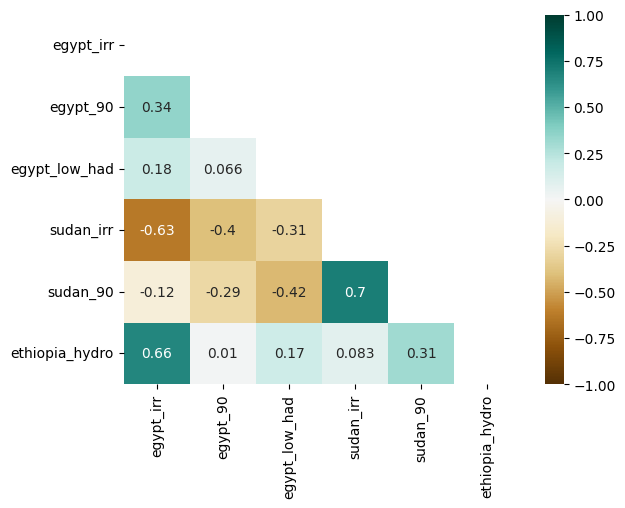

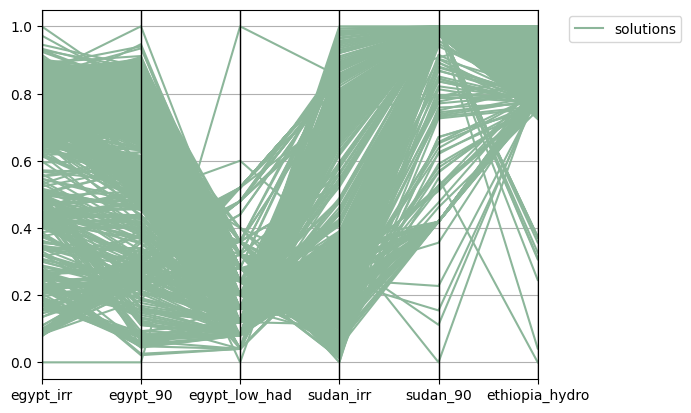

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        1.000000  0.865261      -0.133811  -0.953848 -0.236793   
egypt_90         0.865261  1.000000       0.175343  -0.918989 -0.126768   
egypt_low_had   -0.133811  0.175343       1.000000  -0.110853  0.028104   
sudan_irr       -0.953848 -0.918989      -0.110853   1.000000  0.228086   
sudan_90        -0.236793 -0.126768       0.028104   0.228086  1.000000   
ethiopia_hydro   0.649258  0.564967      -0.050281  -0.683694 -0.130367   

                ethiopia_hydro  
egypt_irr             0.649258  
egypt_90              0.564967  
egypt_low_had        -0.050281  
sudan_irr            -0.683694  
sudan_90             -0.130367  
ethiopia_hydro        1.000000  
           egypt_irr     egypt_90  egypt_low_had     sudan_irr    sudan_90  \
count     850.000000   850.000000     850.000000    850.000000  850.000000   
mean   680345.663343  7035.867943       0.156431  15516.069678    5.245423   
std      

<ipython-input-8-f08829f939ff>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_df, dtype=np.bool))


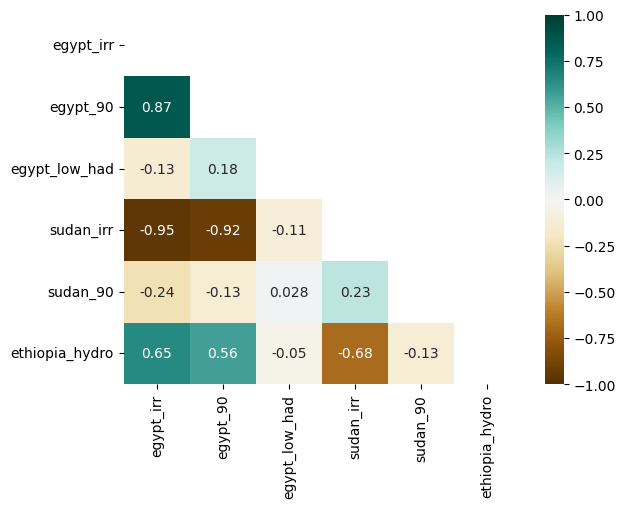

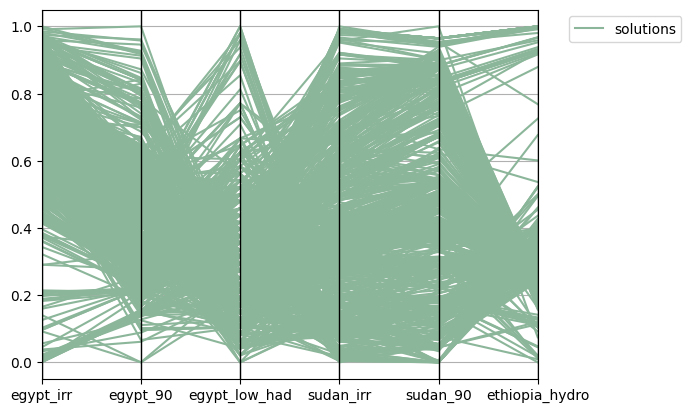

                egypt_irr  egypt_90  egypt_low_had  sudan_irr  sudan_90  \
egypt_irr        1.000000  0.628927      -0.081065  -0.899816 -0.780858   
egypt_90         0.628927  1.000000      -0.191718  -0.720895 -0.739556   
egypt_low_had   -0.081065 -0.191718       1.000000   0.077765  0.170082   
sudan_irr       -0.899816 -0.720895       0.077765   1.000000  0.947250   
sudan_90        -0.780858 -0.739556       0.170082   0.947250  1.000000   
ethiopia_hydro   0.657437  0.215486       0.327179  -0.385111 -0.242210   

                ethiopia_hydro  
egypt_irr             0.657437  
egypt_90              0.215486  
egypt_low_had         0.327179  
sudan_irr            -0.385111  
sudan_90             -0.242210  
ethiopia_hydro        1.000000  
           egypt_irr     egypt_90  egypt_low_had     sudan_irr     sudan_90  \
count     850.000000   850.000000     850.000000    850.000000   850.000000   
mean   757366.809200  7652.492054       0.619809  55270.145108   901.839711   
std   

<ipython-input-8-f08829f939ff>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_df, dtype=np.bool))


In [8]:
scenario_indexes = {scen: list(experiments.loc[experiments["scenario"] == scen].index) for scen in experiments["scenario"].unique()}

for scen, indexes in scenario_indexes.items():
    print("---------------------------------")
    print(scen)
    print("---------------------------------")
    norm_df, desire_couples = normalize_objs(
        outcomes.loc[indexes], ["min", "min", "min", "min", "min", "max"]
    )
    norm_df["class"] = "solutions"
    fig, ax = plt.subplots()
    parallel_coordinates(norm_df, "class", ax=ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()
    corr_df = outcomes.loc[indexes].corr()
    print(corr_df)
    mask = np.triu(np.ones_like(corr_df, dtype=np.bool))
    sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
#     sns.pairplot(outcomes.loc[indexes])
    print(outcomes.loc[indexes].describe())
    
    